In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F 
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
import torch.nn as nn
import matplotlib
import seaborn as sns
%matplotlib inline

In [2]:
data = MNIST(root = 'data',download=True,transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
data[1][0].shape

torch.Size([1, 28, 28])

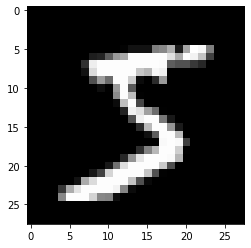

In [4]:
plt.imshow(data[0][0][0],cmap='gray')

In [5]:
val_size = 10000
train_size = len(data) - val_size
train_ds, val_ds = random_split(data,[train_size,val_size])

In [6]:
len(train_ds), len(val_ds),len(data)

(50000, 10000, 60000)

In [7]:
batch_size= 128

train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds,batch_size,num_workers=4,pin_memory=True)

torch.Size([128, 1, 28, 28])


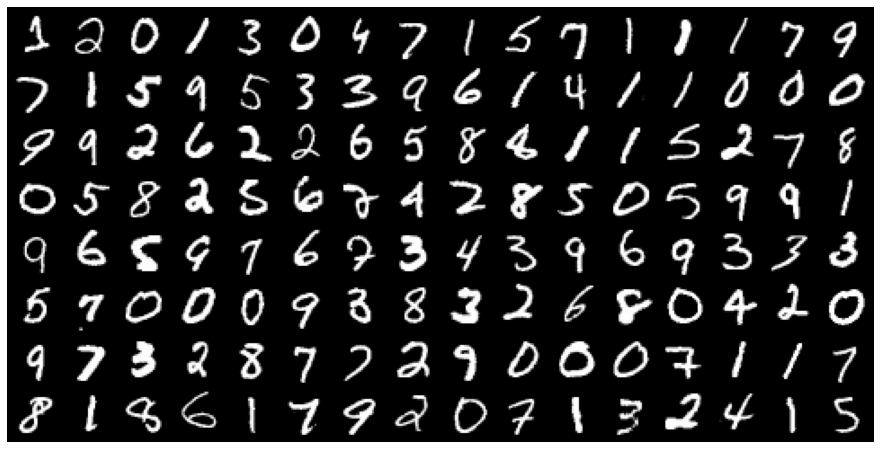

In [8]:
for images,_ in train_dl:
  print(images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
  break

In [9]:
layer1 = nn.Linear(784,32) #hidden layer

In [10]:
layer2 = nn.Linear(32,10) #output layer

In [46]:
class MnistModel(nn.Module):


  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(784,32)
    self.linear2 = nn.Linear(32,10)

  def forward(self,xb):
    xb = xb.reshape(xb.size(0),-1)
    out = self.linear1(xb)
    out = F.relu(out)

    out = self.linear2(out)

    return out

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)

    acc = accuracy(out,labels)

    return {"val_loss":loss,"val_acc":acc}

  def validarion_epoch_step(self,batch):
    batch_loss = [x['val_loss'] for x in batch]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in batch]
    epoch_acc = torch.stack(batch_acc).mean()

    return {'val_loss': epoch_loss.item(),"val_acc":epoch_acc.item()}

  def epoch_end(self,epoch,result):

    print("Epoch [{}] val_loss: {:.4f} val_accuracy {:.4f}".format(epoch,result['val_loss'],result['val_acc']))


model = MnistModel()


In [13]:
def accuracy(outputs,label):
  _,preds = torch.max(outputs,dim=1)

  return torch.tensor(torch.sum(preds==label).item()) / len(outputs)

In [18]:
torch.cuda.is_available() #check if gpu is avaliable and required nvidia cuda drivers are installed

True

In [19]:
def get_default_device():
  #uses gpu if available, if not then uses cpu
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [20]:
device = get_default_device()

In [22]:
device

device(type='cuda')

In [32]:
def move_to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [move_to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [33]:
class DeviceDataLoader():
  
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device


  def __iter__(self):
    
    for b in self.dl:
      yield move_to_device(b,self.device)

  def __len__(self):
    return len(self.dl)

In [34]:
train_loader = DeviceDataLoader(train_dl,device)
val_loader = DeviceDataLoader(val_dl,device)

In [39]:
def evaluate(model,val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validarion_epoch_step(outputs)


In [54]:
def fit(epochs,lr,model,train_loader,val_loader,opt=torch.optim.SGD):
  optimizer = opt(model.parameters(),lr)
  history = []


  for epoch in range(epochs):


    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    results = evaluate(model,val_loader)
    model.epoch_end(epoch,results)
    history.append(results)

  return history

In [48]:
move_to_device(model,device) #move model parameters and model to GPU

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [49]:
history = [evaluate(model,val_loader)]

In [50]:
history

[{'val_acc': 0.09384889155626297, 'val_loss': 2.3151652812957764}]

In [55]:
history += fit(5,0.5,model,train_loader,val_loader)

Epoch [0] val_loss: 0.1552 val_accuracy 0.9554
Epoch [1] val_loss: 0.1510 val_accuracy 0.9549
Epoch [2] val_loss: 0.1203 val_accuracy 0.9641
Epoch [3] val_loss: 0.1190 val_accuracy 0.9624
Epoch [4] val_loss: 0.1076 val_accuracy 0.9676


In [56]:
history += fit(5,0.1,model,train_loader,val_loader)

Epoch [0] val_loss: 0.1004 val_accuracy 0.9690
Epoch [1] val_loss: 0.0996 val_accuracy 0.9693
Epoch [2] val_loss: 0.0999 val_accuracy 0.9705
Epoch [3] val_loss: 0.0997 val_accuracy 0.9688
Epoch [4] val_loss: 0.0999 val_accuracy 0.9690


In [57]:
history += fit(5,0.001,model,train_loader,val_loader)

Epoch [0] val_loss: 0.0992 val_accuracy 0.9694
Epoch [1] val_loss: 0.0989 val_accuracy 0.9696
Epoch [2] val_loss: 0.0986 val_accuracy 0.9695
Epoch [3] val_loss: 0.0985 val_accuracy 0.9697
Epoch [4] val_loss: 0.0984 val_accuracy 0.9699


In [ ]:
#97% acc